# Import package and data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [2]:
current_dir = os.getcwd()
project_dir = os.path.abspath(os.path.join(current_dir, ".."))
DATA_PATH = f"{project_dir}/data/"
data = pd.read_csv(DATA_PATH+"2016_Building_Energy_Benchmarking.csv", sep=",", encoding="iso-8859-1")

In [3]:
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


# Phase 1

## Cleaning

In [4]:
pd.set_option('display.max_info_rows',50)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   OSEBuildingID                    int64  
 1   DataYear                         int64  
 2   BuildingType                     object 
 3   PrimaryPropertyType              object 
 4   PropertyName                     object 
 5   Address                          object 
 6   City                             object 
 7   State                            object 
 8   ZipCode                          float64
 9   TaxParcelIdentificationNumber    object 
 10  CouncilDistrictCode              int64  
 11  Neighborhood                     object 
 12  Latitude                         float64
 13  Longitude                        float64
 14  YearBuilt                        int64  
 15  NumberofBuildings                float64
 16  NumberofFloors                   int64  
 17  PropertyGFATot

In [5]:
data.isna().mean()[data.isna().mean() > 0.10]

SecondLargestPropertyUseType       0.502666
SecondLargestPropertyUseTypeGFA    0.502666
ThirdLargestPropertyUseType        0.823460
ThirdLargestPropertyUseTypeGFA     0.823460
YearsENERGYSTARCertified           0.964751
ENERGYSTARScore                    0.249704
Comments                           1.000000
Outlier                            0.990521
dtype: float64

In [6]:
label_1 = "SiteEnergyUse(kBtu)"
label_2 = "TotalGHGEmissions"

In [7]:
all_columns = list(data.columns)
categorical_columns = ["BuildingType", "PrimaryPropertyType","PropertyName","City","State","Address","City","State",
                       "ZipCode","CouncilDistrictCode","Neighborhood","ListOfAllPropertyUseTypes",
                       "LargestPropertyUseType","SecondLargestPropertyUseType","ThirdLargestPropertyUseType","ComplianceStatus"]
numerical_columns = [column for column in all_columns if column not in categorical_columns]

In [8]:
# Premier nettoyage du dataframe
def clean_data(df, to_drop):
    print("--------- shape before cleaning ---------")
    print(df.shape)
    df = df[df.ComplianceStatus == "Compliant"]
    df.Outlier.fillna('not_outlier', inplace=True)
    df.SecondLargestPropertyUseType.fillna('one_use', inplace=True)
    df.ThirdLargestPropertyUseType.fillna('one_use', inplace=True)
    df = df[df.NumberofBuildings != 0]
    df = df[df.NumberofFloors != 0]
    df = df[df['DefaultData'] == False]
    df.loc[df['SecondLargestPropertyUseType'] == 'one_use', 'SecondLargestPropertyUseTypeGFA'] = 0
    df.loc[df['ThirdLargestPropertyUseType'] == 'one_use', 'ThirdLargestPropertyUseTypeGFA'] = 0
    df['Nb_PropertyUseTypes'] = df['ListOfAllPropertyUseTypes'].str.count(',') + 1
    df["Building_age"] = df["DataYear"] - df["YearBuilt"]
    df['LargestPropertyUseType'] = df['LargestPropertyUseType'].fillna(df['PrimaryPropertyType'])
    df['LargestPropertyUseTypeGFA'] = df['LargestPropertyUseTypeGFA'].fillna(df['PropertyGFATotal'])
    df["%_LargestPropertyUseType"] = df["LargestPropertyUseTypeGFA"] / df["PropertyGFATotal"]    
    for col in to_drop:
        if col in df.columns:
            df = df.drop(columns=[col])
    print("--------- shape before cleaning ---------")
    print(df.shape)
    return df

# Mise à jour des listes des colonnes
def update_columns_list(list_1, dropped):
    new_list = [col for col in list_1 if col not in dropped]
    return new_list

In [9]:
# Vérifier la GFA
data["GFATotal"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]
check_GPA = pd.Series(data["GFATotal"] == data["PropertyGFATotal"])
data.drop(columns=["GFATotal"], inplace=True)
check_GPA.value_counts()

True    3376
dtype: int64

In [10]:
data = data[~data.BuildingType.isin(["Multifamily LR (1-4)","Multifamily MR (5-9)","Multifamily HR (10+)"])]
data["%_GFAParking"] = data["PropertyGFAParking"] / data["PropertyGFATotal"]
data["%_GFABuilding"] = data["PropertyGFABuilding(s)"] / data["PropertyGFATotal"]


In [11]:
columns_to_drop = ["DataYear","PropertyName","Address","City","State",
                "Latitude","Longitude","YearBuilt","TaxParcelIdentificationNumber",
                "YearsENERGYSTARCertified","Comments","DefaultData","ComplianceStatus",
                "SiteEnergyUseWN(kBtu)","PropertyGFAParking","PropertyGFABuilding(s)","ListOfAllPropertyUseTypes"]

In [12]:
data = clean_data(data, columns_to_drop)
categorical_columns = update_columns_list(categorical_columns,columns_to_drop)

--------- shape before cleaning ---------
(1668, 48)
--------- shape before cleaning ---------
(1481, 34)


In [13]:
data.BuildingType.value_counts()

NonResidential        1375
Nonresidential COS      73
Campus                  22
SPS-District K-12       10
Nonresidential WA        1
Name: BuildingType, dtype: int64

In [14]:
pd.set_option('display.max_columns',50)
data.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity,%_GFAParking,%_GFABuilding,Nb_PropertyUseTypes,Building_age,%_LargestPropertyUseType
0,1,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,12,88434,Hotel,88434.0,one_use,0.0,one_use,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,not_outlier,249.98,2.83,0.000000,1.000000,1,89,1.000000
1,2,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,11,103566,Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,not_outlier,295.86,2.86,0.145453,0.854547,3,20,0.809918
2,3,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,41,956110,Hotel,756493.0,one_use,0.0,one_use,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,not_outlier,2089.28,2.19,0.205748,0.794252,1,47,0.791220
3,5,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,10,61320,Hotel,61320.0,one_use,0.0,one_use,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,not_outlier,286.43,4.67,0.000000,1.000000,1,90,1.000000
4,8,NonResidential,Hotel,98121.0,7,DOWNTOWN,1.0,18,175580,Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,not_outlier,505.01,2.88,0.353115,0.646885,3,36,0.703070


In [15]:
data.ENERGYSTARScore = data.ENERGYSTARScore.fillna('no_score')
data = data[data["ENERGYSTARScore"] != 'no_score']

## Exploration label

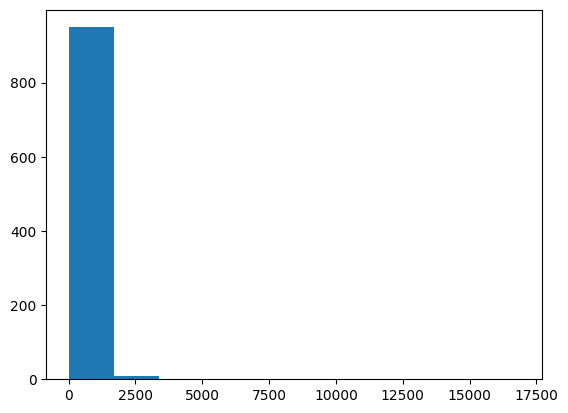

In [16]:
plt.hist(data["TotalGHGEmissions"]);

In [17]:
data["TotalGHGEmissions"].describe()

count      964.000000
mean       193.268672
std        873.974092
min         -0.800000
25%         20.165000
50%         49.215000
75%        140.090000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

In [18]:
data["TotalGHGEmissions"].quantile([0, .5, 0.98])

0.00      -0.8000
0.50      49.2150
0.98    1008.6684
Name: TotalGHGEmissions, dtype: float64

In [19]:
data = data[data["TotalGHGEmissions"] <= data["TotalGHGEmissions"].quantile([0.98])[0.98]]
data = data[data["TotalGHGEmissions"] > 0]

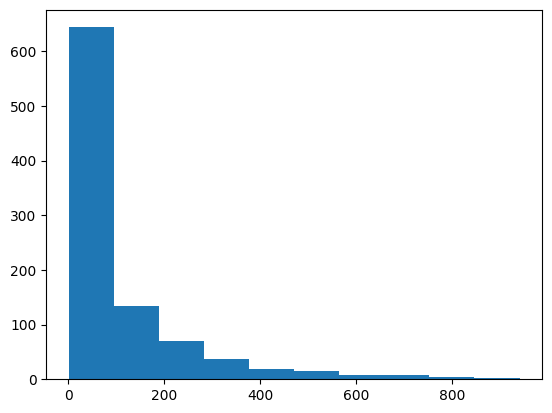

In [20]:
plt.hist(data[label_2]);

In [21]:
data[label_1].describe()

count    9.420000e+02
mean     6.206883e+06
std      9.461551e+06
min      7.971180e+04
25%      1.236609e+06
50%      2.687720e+06
75%      7.033444e+06
max      9.293764e+07
Name: SiteEnergyUse(kBtu), dtype: float64

In [22]:
data[label_2].describe()

count    942.000000
mean     106.159830
std      145.085844
min        0.810000
25%       19.937500
50%       47.975000
75%      130.575000
max      940.470000
Name: TotalGHGEmissions, dtype: float64

# Features correlation

In [38]:
heatmap_column = update_columns_list(data.columns, dropped=['OSEBuildingID',
'ZipCode'])

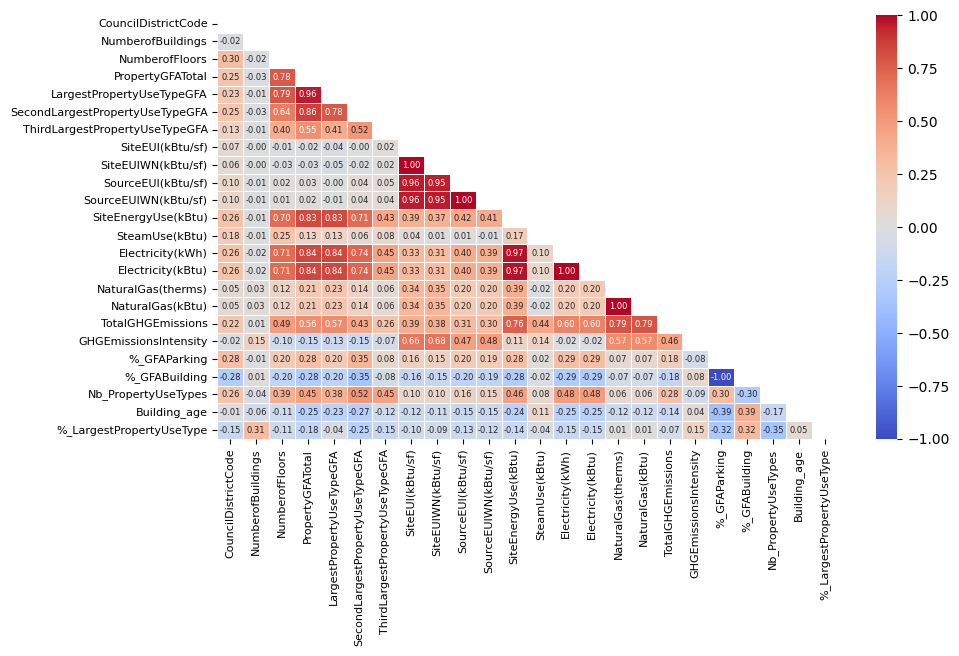

In [44]:
data_heatmap = data[heatmap_column]

fig, ax = plt.subplots(figsize=(10,5.5))
mask = np.triu(np.ones_like(data_heatmap.corr(), dtype=np.bool))
heatmap = sns.heatmap(data_heatmap.corr(),annot=True, fmt=".2f", mask=mask, cmap='coolwarm', linewidths=.5, annot_kws={"fontsize": 6})

# Diminution de la taille de police des labels des axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

# Affichage de la figure
plt.show()

In [23]:
data.to_csv(DATA_PATH+"data.csv", sep=",", index=False, encoding="iso-8859-1")